In [1]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

from konlpy.tag import Okt
import tensorflow as tf

In [2]:
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
whole_reviews = pd.read_csv('./lec_review.csv')
sw_reviews = pd.read_csv('./sw_lec_review.csv')

In [4]:
print(whole_reviews.groupby(whole_reviews['star']).size())
whole_reviews.replace({'star': 3}, 2, inplace=True)

print('change rating 3 to 2')
print(whole_reviews.groupby(whole_reviews['star']).size())

star
1     260
2     173
3     426
4     531
5    1210
dtype: int64
change rating 3 to 2
star
1     260
2     599
4     531
5    1210
dtype: int64


In [5]:
okt = Okt()

def clean_text(text:str) -> str:
    text = okt.pos(text, norm = True, stem = True)
    res = []
    conti = False
    for txt in text:           
        if (txt[1] == "Adjective" or txt[1] == "Noun" or
            txt[1] == "Verb" or txt[1] == "Adjective" or 
            txt[1] == "Suffix" or txt[1] =="KoreanParticle"):
            res.append(txt[0])
            prev = (txt[0], txt[1])
        
    
    return " ".join(res)

In [6]:
sw_reviews.head()
sw_reviews.columns = ['lecture', 'professor', 'review']

In [7]:
whole_reviews['clean_text'] = whole_reviews['review'].map(clean_text)
sw_reviews['clean_text'] = sw_reviews['review'].map(clean_text)

In [8]:
whole_reviews.head()

,review,star,pos_neg,clean_text
0,전공 두개 합친만큼 신경써야 점수가 나오는 신기한 강의,2,neg,전공 개 합치다 신경 써다 점수 나오다 신기하다 강의
1,재수강하러갑니다.시험 대부분 문제가 주관식으로 나오는데 구절 빈칸넣기라던가 스토리보...,1,neg,재수강 하다 가다 시험 대부분 문제 주관 식 나오다 구절 빈칸 넣기 스토리 세다 내...
2,성적 너그러이주심. 강의력은 조금부족하긴한데 설명잘해주심,2,mid,성적 너그럽다 주심 강의 력 조금 부족하다 설명 잘해주다 심
3,1. 수강 자체는 굉장히 편함2. 기말고사는 어려운데 패스 자체에 영향을 미치진 않는듯,4,pos,수강 자체 굉장하다 편하다 기말고사 어렵다 패스 자체 영향 미치다 않다
4,1. 교수님이 인도사 전공으로 사실상 쟁점인도사2. 과제가 소소하게 많지만 어렵거나...,5,pos,교수 님 인도 사 전공 사실 상 쟁점 도사 과제 소소하다 많다 어렵다 시간 과제 아니다


In [9]:
sw_reviews['star'] = np.NaN
sw_reviews.head()

,lecture,professor,review,clean_text,star
0,Capstone디자인(산학협력프로젝트),"권기학, 문현준",보고서가 많은편이긴한데학점은퍼주네요 굳,보고서 많다 편이 기다 학점 퍼 주네 굳다,NaN
1,C프로그래밍및실습,김도년,수업끝나고 수업시간에 진행한 코드작성 못하면 남아서 될냐까지 해야함 그런거 빼고 낫...,수업 끝나다 수업 시간 진행 코드 작성 하다 남아 되다 하다 함 그렇다 빼다 낫밷,NaN
2,C프로그래밍및실습,김도년,실습끝까지 남기시는 거 뺴곤 아주좋으심 너그러우신편,실습 끝 남다 거 뺴곤 아주 좋다 심 너그럽다 편,NaN
3,C프로그래밍및실습,김도년,교수님 엄청 친절하시고 귀여우셔요..과제만열심히 제때제때하면 되니까 그거만으로도 충...,교수 님 친절하다 귀엽다 과제 제때 제때 하 되다 그거 충분하다 실력 올리다 수 있다,NaN
4,C프로그래밍및실습,김도년,교수님 과제많아서 시험준비는 과제한거 복습하면됨. 귀여우심,교수 님 과제 많다 시험 준비 과제 거 복습 하다 되다 여우 심,NaN


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(whole_reviews['clean_text'], whole_reviews['star'], test_size=0.2, random_state=42)

In [11]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test  shape: {X_test.shape}')

X_train shape: (2080,)
X_test  shape: (520,)


In [12]:
train_text = list(X_train)
train_sent = list(y_train)

test_text = list(X_test)
test_sent = list(y_test)

# DL model

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_text)

train_data = tokenizer.texts_to_sequences(train_text)
test_data  = tokenizer.texts_to_sequences(test_text)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing import sequence

trainX = sequence.pad_sequences(train_data, maxlen=100)
testX  = sequence.pad_sequences(test_data, maxlen=100)

In [15]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
        
    return results

trainX = vectorize_sequences(train_data)
testX  = vectorize_sequences(test_data)

In [16]:
from tensorflow.keras.utils import to_categorical

trainY = to_categorical(train_sent)
testY  = to_categorical(test_sent)

In [17]:
from tensorflow.keras import models, layers

model = models.Sequential()

model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(6,  activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
history = model.fit(trainX, trainY, batch_size=512, epochs=20,
                    validation_data=(testX, testY))

Epoch 1/20
5/5 [==============================] - 0s 65ms/step - loss: 1.7108 - accuracy: 0.3909 - val_loss: 1.5456 - val_accuracy: 0.5481
Epoch 2/20
5/5 [==============================] - 0s 15ms/step - loss: 1.4394 - accuracy: 0.5822 - val_loss: 1.3564 - val_accuracy: 0.5327
Epoch 3/20
5/5 [==============================] - 0s 12ms/step - loss: 1.2245 - accuracy: 0.5942 - val_loss: 1.2259 - val_accuracy: 0.6019
Epoch 4/20
5/5 [==============================] - 0s 13ms/step - loss: 1.0532 - accuracy: 0.6812 - val_loss: 1.1274 - val_accuracy: 0.6596
Epoch 5/20
5/5 [==============================] - 0s 12ms/step - loss: 0.9128 - accuracy: 0.7538 - val_loss: 1.0587 - val_accuracy: 0.6596
Epoch 6/20
5/5 [==============================] - 0s 13ms/step - loss: 0.7960 - accuracy: 0.8019 - val_loss: 0.9785 - val_accuracy: 0.6558
Epoch 7/20
5/5 [==============================] - 0s 13ms/step - loss: 0.6958 - accuracy: 0.8389 - val_loss: 0.9476 - val_accuracy: 0.6712
Epoch 8/20
5/5 [===========

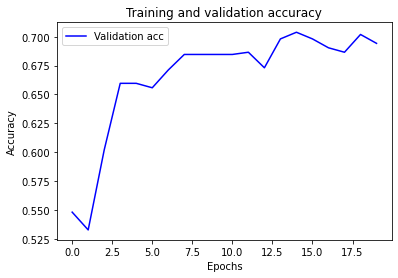

In [19]:
val_acc = history.history['val_accuracy']

plt.plot(val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [20]:
model = models.Sequential()

model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(testX, testY, batch_size=512, epochs=30,
            validation_data=(testX, testY))

results = model.evaluate(testX, testY)

Epoch 1/30
2/2 [==============================] - 0s 134ms/step - loss: 1.7939 - accuracy: 0.1731 - val_loss: 1.6862 - val_accuracy: 0.5096
Epoch 2/30
2/2 [==============================] - 0s 14ms/step - loss: 1.6847 - accuracy: 0.5096 - val_loss: 1.5604 - val_accuracy: 0.4827
Epoch 3/30
2/2 [==============================] - 0s 14ms/step - loss: 1.5598 - accuracy: 0.4827 - val_loss: 1.4598 - val_accuracy: 0.4827
Epoch 4/30
2/2 [==============================] - 0s 16ms/step - loss: 1.4591 - accuracy: 0.4827 - val_loss: 1.3638 - val_accuracy: 0.4827
Epoch 5/30
2/2 [==============================] - 0s 13ms/step - loss: 1.3630 - accuracy: 0.4827 - val_loss: 1.2937 - val_accuracy: 0.5269
Epoch 6/30
2/2 [==============================] - 0s 15ms/step - loss: 1.2936 - accuracy: 0.5269 - val_loss: 1.2323 - val_accuracy: 0.5942
Epoch 7/30
2/2 [==============================] - 0s 11ms/step - loss: 1.2323 - accuracy: 0.5942 - val_loss: 1.1774 - val_accuracy: 0.6135
Epoch 8/30
2/2 [==========

In [21]:
results

[0.32357728481292725, 0.9673076868057251]

In [22]:
mean = 0
for i in range(len(test_sent)):
    text = clean_text(test_text[i])
    text = tokenizer.texts_to_sequences([text])
    text = vectorize_sequences(text)
    pred = model.predict(text)

    print(test_text[i], "\n예측:",np.argmax(pred[0]),"실제:",test_sent[i], end = "\n===============\n")
    mean += abs(test_sent[i]- np.argmax(pred[0]))

과제 어렵다 동영상 강의 반복 하다 들다 좋다 
예측: 2 실제: 2
세종 강제 봉사 세기 인력 착취 
예측: 1 실제: 1
내 살다 만난 교수 님 들다 중 제일 좋다 학점 자다 챙기다 주심 
예측: 5 실제: 5
시험 없다 패스 파일 과목 꿀 강의 하다 수강 하다 글쎄 쓰레기 돈 주다 산 느낌 앞서 말 하다 시험 없다 학점 따다 용 괜찮다 수 있다 돈 찢다 한강 내다 버리다 게 덜 아깝다 정도 생각 되다 수업 내용 뿐이다 
예측: 1 실제: 1
모임 없다 행복하다 수업 내용 어렵다 기도 하다 강의 조금 지루하다 때 있다 힘들다 들다 수업 이다 
예측: 4 실제: 4
녹강 편하다 과제 텀 길다 마감 기간 메세지 계속 날다 편하다 
예측: 5 실제: 5
수업 내용 방식 등 깐깐하다 않다 편안함 배우다 내용 인생 용이 어렵다 않다 과제 포폴 보고 이마 탁 칠 수 있다 시험 좀 당황 스럽다 과제 포폴 하다 부담 않다 ㄱㅊ 
예측: 2 실제: 2
물리 이론 이상하다 반감 있다 듯 양자역학 같다 하다 때 좀 놀라다 천문 하 양자 모르다 되다 
예측: 2 실제: 2
강의 평 보고 걱정 하다 생각 교수 님 좋다 심 논문 좀 뒤지다 내용 이해 하다 되다 생각 하다 거리 별로 없다 글 나다 
예측: 4 실제: 4
말 하다 뭐 하다 가현 교수 님 수업 믿다 듣다 좋다 
예측: 5 실제: 5
내용 쉽다 하다 듯 올려주다 빼다 좋다 계속 실 강하다 알다 녹강 나이스 
예측: 5 실제: 5
생각 영상 강의 력 좋다 진도 영상 제때 올려주다 ㅠㅠ 
예측: 2 실제: 2
삼성 별 를 지내다 존경 하다 황보 현 교수 님 만세 
예측: 5 실제: 5
시험 컨에프 통해 커버 가능 하다 컨에프 믿다 안되다 강의 듣다 공부 필요하다 
예측: 4 실제: 4
강의 이해 쉽다 다른 사람 들 이 강의 추천 싶다 
예측: 5 실제: 5
실로 교수 님 학생 들 입장 배려 하다 교수 님 이세 강의 정말 자다 가르치다 
예측: 5 실제: 5
강의 좀 어렵다 시험 객관 식 책 읽다 행정법 지식 쌓이다 느낌 들어

가현 말 필요 없다 친절하다 학생 들 생각 제일 해 주심 수업 내용 많다 않다 나가다 전혀 어리다 없다 들다 수 있다 꼭 들다 
예측: 5 실제: 5
영상 보고 계속 혼자 공부 하다 되다 혼자 하다 어렵다 기초 자다 되어다 있다 쉽다 기초 확실하다 알다 줌 
예측: 2 실제: 2
성적 너그럽다 주심 강의 력 조금 부족하다 설명 잘해주다 심 
예측: 2 실제: 2
시간 투자 하다 필요 없다 정도 하다 되다 과목 평균 높다 과제 들다 해오다 그렇다 점수 대가 높다 스포츠 관심 있다 듣기 좋다 생각 함 
예측: 4 실제: 4
학년 때 들다 수업 중 제일 최악 
예측: 1 실제: 1
수업 때 캠 안 켜다 좋다 안 빡세 
예측: 5 실제: 5
강연 재밌다 꿀강 친절하다 좋다 놓치다 말다 
예측: 5 실제: 5
좋다 진로 대해 탐색 하다 수 있다 과제 어렵다 않다 
예측: 5 실제: 5
영상 듣다 문제 푸다 문제 틀리다 다시 하다 수 있다 좋다 
예측: 5 실제: 5
인품 강의 력 열정 뭐 하나 부족함 없다 
예측: 5 실제: 5
과제 미리 미리 해 아니다 절망 적 
예측: 5 실제: 1
교수 동영상 나오다 가다 하다 일 강의 교안 읽다 학생 하다 일 시간 낭비 
예측: 1 실제: 1
교수 님 좋다 내용 생각 깊다 들어가다 좋다 저 그리스 로마 신화 워낙 좋아하다 관련 분야 관심 많다 정말 재밌다 들다 그렇다 분 들 듣기 확실하다 좀 힘들다 것 같다 느낌 들다 과제 없다 캠 안키 편하다 수업 이기다 문제 꼼꼼하다 내다 쉽다 교양 하다 
예측: 4 실제: 4
필기체 좀 알아보다 수 없다 집중 하다 들다 알아보다 수 있다 변수 미적분학 과목 자체 별로 어렵다 않다 때문 난이도 쉽다 생각 하다 또 교수 님 예제 풀다 때문 이해 매우 쉬다 되다 개인 적 시험 매우 쉽다 생각 하다 수학 하다 강의 자다 들다 나오다 
예측: 5 실제: 5
도망가다 하다 많다 점수 진짜 최악 
예측: 2 실제: 2
기다 수업 시간 비다 나가다 진도 많다 것 같다 않다 
예측: 2 실제: 2
과제 있

자다 이야기 해주다 그냥 틀어놓다 듣다 듯 패논패 해주다 좋다 
예측: 2 실제: 2
더 이상 것 꿀 교가 아니다 시험 은근 난이도 있다 비위 약하다 편 징그럽다 사진 좀 많다 보다 보다 문제 나오다 거 같다 부분 보이다 함 
예측: 4 실제: 4
퀴즈 있다 개 어렵다 무슨 몇 페이지 첫 문단 적다 거 있다 들다 어렵다 하다 성심 성의껏 보다 돼다 팀 빡셈 피드백 그때 그때 하다 하다 시간 뺏다 겨 저 팀 장 하다 평일 전화 서다 화 내다 조원 들 늦다 팀 장이 끄다 ㅠㅠㅠ 팀 장이 부팀 장하다 가산 점 얻다 글 하다 일 똑같다 왜 팀 장 점 부팀 장 전인 이해 안되다 들다 하다 무조건 팀 장하다 에세이 피드백 두 번 해주다 참고 저 각주 달다 법 틀리다 피드백 받다 점수 꽤 깍이다 뭐 틀리다 싶다 다르마 칼리지 상 받다 에세이 각주 달다 최종 제출 하다 그 때 각주 달다 법 틀리다 점수 깍이다 여러분 들 혼나다 꼭 물어보다 뭘 원하다 건지다 모르다 학점 저 팀 장 하다 그렇다 나쁘다 않다 그냥 강의 평 그대로 강의 하다 게 많다 좀 짜증나다 교수 님 승질 당황 스럽다 가장 세미나 다운 세미나 
예측: 4 실제: 4
교수 님 친절하다 좋다 시험 번역 만평 해석 나오다 평소 만평 관심 많다 분 들 쉬다 보다 수 있다 것 같다 시험 볼 때 교수 님 조교 님 오다 감독 하다 
예측: 4 실제: 4
노베 관점 쓰다 강의 속도 매우 빠르다 필기 속도 교수 님 설명 하다 속도 못 따라가다 이번 학기 비 대면 강의 돌리다 보다 놓치다 부분 필기 하다 수 있다 걸 대면 때 들다 분들 정말 대단하다 심 문법 설명 두서 없다 최대한 반복 하다 문법 익히다 하다 의도 수 있다 거 같다 계속 뒤쪽 단원 문법 설명 끌다 해당 과 배우다 않다 문법 사항 본문 나오다 방식 어지러움 시험 문제 안 배우다 단어 들 나오다 추론 필요 이렇다 문제 들 교재 사서 추가 적 공부 하다 상위 권 유지 가능하다 쉬다 생각 하다 크다 코 다치다 단순하다 스페인어 회화 배우다 마음가짐 임 하다 위험하다 

하다 하다 일만 하다 전혀 문제 없다 교수 님 서도 친절하다 생각 즐겁다 수업 
예측: 5 실제: 5
성적 주다 하다 모르다 혼자 독학 하다 하다 
예측: 2 실제: 2
카지노 좀 하다 알 에쁠 씹다 가능 ㅋㅋ 딱하다 어렵다 없다 과제 이제 취업 관련 해주다 호카 복전 같다 생각 하다 무조건 듣다 추천 
예측: 5 실제: 5
수업 비대 녹강 진행 하다 시험 대체 과제 비대 시험 대면 시험 투표 결정 함 교수 님 대체 과제 생각 하다 과 제량 줄이다 학생 생각 해주시 교수 님 생각 함 
예측: 5 실제: 5
시험 기간 갑자기 수필 쓰다 그렇다 시험 기간 왜 물어보다 건지다 과제 시험 기간 몰다 주심 시험 전날 새벽 수필 쓰다 싶다 않다 이 강의 비추다 
예측: 2 실제: 2
교수 님 긔욥시험 어렵다 않다 수준 나오다 퀴즈 과제 가다 다른 사이트 진행 되다 때문 개 착각 하다 자다 하다 수 있다 
예측: 5 실제: 5
그냥 틀어놓다 꼬박꼬박 기간 알다 영상 보다 되다 과제 번 자다 내면 패스 받다 
예측: 5 실제: 5
중간 대체 과제 전혀 부담 없다 수업 너그럽다 정말 부딤없 듣기 좋다 
예측: 4 실제: 4
편하다 수업 듣기 좋다 목소리 조금 졸리다 수업 듣다 보다 시간 자다 가요 
예측: 5 실제: 5
교수 님 좋다 신분 데 수업 시간 방탄 얘기 심 ㅠㅠ 레포트 빡세 시험 좀 어렵다 
예측: 2 실제: 2
과제 나가다 난이도 높다 않다 말 말 조금 보다 큰일 요 
예측: 4 실제: 4
헬창 재 헬스 얘기 듣다 수업 헬스 원래 하다 사람 이면 알다 내용 그냥 편안하다 들다 수 있다 
예측: 5 실제: 5
첫 강평 말 믿다 말다 그냥 회부 적응 자 생각 하다 되다 것 같다 교수 님 강의 하다 
예측: 5 실제: 5
그냥 듣다 끝내다 추천 드리다 금방 듣다 풀다 문제 수준 저 나오다 들다 
예측: 5 실제: 5
갓승숙 퀸승숙 빛승숙 교수 님 안녕하십니까 로 시작 하다 강의 평 다른 글쓰기 강의 수강 하 하다 감히 최고 글쓰기 강의 자부 하다 일단 평가 방식 먼저 

성격 ㄹㅈㄷ 이심 성격 급하다 말 하다 스타일 듯 피드백 정확하다 주시 듯 
예측: 2 실제: 2
교수 님 좋다 재밌다 쉬다 알다 주심 시험 쉽다 시험 문제 몇 개다 알다 것 기억 함 
예측: 5 실제: 5
말 분량 어이없다 ㅋㅋ 
예측: 2 실제: 2
좋다 분 같다 제 안해 그렇다 
예측: 5 실제: 5
교수 님 강의 력 좋다 학생 의견 반영 자다 해주다 실습 과제 있다 말 시험 팀 과제 좀 힘들다 
예측: 5 실제: 5
영상 보고 퀴즈 풀 되다 전혀 어렵다 않다 
예측: 5 실제: 5
물리 특유 이론 알 틀리다 문제 들 그대로 나오다 예제 보지 집사 풀다 보다 추천 
예측: 2 실제: 2
책 읽다 수준 강의 내용 이 과목 자다 학습 중요하다 이 수업 들다 이유 찾다 하다 이론 설명 부족하다 것 비다 시험 난이도 높다 편이 수업 들다 해당 수업 듣기 전 능력 갖추다 점수 따내다 있다 분 들 듣다 것 추천 부족하다 설명 설명 비다 수준 높다 시험 출결 시험 문제 정도 풀다 기준 미치다 
예측: 1 실제: 1
최악 오픈 북 아니다 이제 더 이상 꿀 아니다 과제 레포트 써다 할양 좀 많다 
예측: 1 실제: 1
교수 님 열정 적 학생 들 의견 반영 해주다 노력 하다 매우 매우 친절하다 개인 적 좋다 
예측: 5 실제: 5
노잼 ㄴ 이다 영화 관심 많다 들다 그냥 책 읽다 살 명 해주시 
예측: 2 실제: 2
교수 님 학생 들 피드백 적극 적 반영 하다 하다 좋다 
예측: 5 실제: 5
과제 없다 퀴즈 두 번 중간 말 보다 요음 교수 님 좋다 데 그리스 로마신화 범위 워낙 많다 보다 어리다 때 읽다 만화책 그 깊이 공부 싶다 비추다 천해 그냥 유튜브 보다 세다 이름 하나 하나 유래 어원 알다 하다 시험 엽 적 출제 되다 것 같다 그냥 편하다 듣다 싶다 듣다 말다 역사 사랑 하다 분만 들다 
예측: 2 실제: 2
중간고사 상대평가 임 불구 내 겪다 시험 중 최악 진행 
예측: 1 실제: 1
강의 자체 편하다 좋다 과제 이렇다 거 다해 종종 손 들 말 하다 않다 학점 

과제 별로 없다 시험 쉬다 학점 자다 주심 
예측: 5 실제: 5
법학과 라면 김희정 교수 님 수업 들다 걸 추천 하다 
예측: 5 실제: 5
개꿀 이다 그냥 꼭 들다 켜다 다른 공부 하다 돼다 
예측: 5 실제: 5
중간고사 과제 대체로 발표 한번 있다 조 짜다 거나 혼자 해도 돼다 발표 하다 싫다 워드 작성 하다 제출 하다 되다 중간고사 없다 널널 강의 편하다 들다 교수 님 정말 천사 같다 좋다 그치다 강의 귀 자다 꽂히다 스타일 아니다 기말고사 때 하다 학기 동안 배우다 모두 시험 범위 처음 다시 듣다 미치다 알다 ㅋㅋㅋ 범위 정 말 많다 요 꿀 교양 듯 아니다 꿀 교양 같다 교양 
예측: 4 실제: 4
시험 난이도 어렵다 않다 강의 력 좋다 말 하다 순 없다 
예측: 4 실제: 4
최고 이다 과제 어렵다 않다 수업 참여 난이도 어렵다 않다 성의 보이 이쁘다 그냥 얻다 강의 
예측: 5 실제: 5
말 느리다 시가 많다 기말고사 걱정 되다 
예측: 2 실제: 2
수업 진짜 자다 심 열정 적 가르치다 모르다 메일 물어보다 친절하다 알다 주심 시험 문제 쉬다 려고 노력 하다 눈 보임 난 치다 ㅋㅋㅋ 물어보다 지다 모르다 수업 들다 무조건 맞다 듯 내 이다 
예측: 5 실제: 5
강연 재밌다 꿀강 친절하다 좋다 놓치다 말다 
예측: 5 실제: 5
과제 쉽다 시험 어렵다 공부 하다 하다 양도 매우 많다 깐깐하다 느끼다 피 튀기다 수강신청 하다 도대체 왜 수강신청 힘 이해 하다 수 없다 수업 
예측: 2 실제: 2
질문 굉장하다 자다 받다 교재 이외 풀 만 문제 들 주다 좋다 그치다 개념 대한 설명 충분하다 하다 느끼다 때 종종 있다 교재 읽다 다른 책 찾아보다 공부 하다 때 있다 그거 빼다 학생 들 관심 정말 많다 좋다 
예측: 4 실제: 4
언어 개월 입문 정도 문제 풀 정도 문제 나오다 작년 다르다 첫 인증 문제 좀 빡세 나오다 구현 연습 미리 하다 풀 함 차 기준 지능 기전 융 대 학과 이면 통과 되다 미리 들이다 혼자 공부 하다 주 가성 비 좋다 성적 나오

In [23]:
error = mean/len(test_sent)
error

0.075

In [24]:
sw_reviews_star = list()

for text in sw_reviews['clean_text']:
    text = clean_text(text)
    text = tokenizer.texts_to_sequences([text])
    text = vectorize_sequences(text)
    pred = model.predict(text)
    sw_reviews_star.append(np.argmax(pred[0]))

In [25]:
sw_reviews['star'] = sw_reviews_star
sw_reviews.head()

,lecture,professor,review,clean_text,star
0,Capstone디자인(산학협력프로젝트),"권기학, 문현준",보고서가 많은편이긴한데학점은퍼주네요 굳,보고서 많다 편이 기다 학점 퍼 주네 굳다,5
1,C프로그래밍및실습,김도년,수업끝나고 수업시간에 진행한 코드작성 못하면 남아서 될냐까지 해야함 그런거 빼고 낫...,수업 끝나다 수업 시간 진행 코드 작성 하다 남아 되다 하다 함 그렇다 빼다 낫밷,4
2,C프로그래밍및실습,김도년,실습끝까지 남기시는 거 뺴곤 아주좋으심 너그러우신편,실습 끝 남다 거 뺴곤 아주 좋다 심 너그럽다 편,5
3,C프로그래밍및실습,김도년,교수님 엄청 친절하시고 귀여우셔요..과제만열심히 제때제때하면 되니까 그거만으로도 충...,교수 님 친절하다 귀엽다 과제 제때 제때 하 되다 그거 충분하다 실력 올리다 수 있다,5
4,C프로그래밍및실습,김도년,교수님 과제많아서 시험준비는 과제한거 복습하면됨. 귀여우심,교수 님 과제 많다 시험 준비 과제 거 복습 하다 되다 여우 심,5


In [26]:
sw_reviews.to_csv('sw_reviews_with_star.csv', index=False)